# Calentamiento: Extrovertido vs Introvertido
> Dataset disponible en https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data.


El objetivo de este dataset es realizar una predicción categórica sobre la variable `Personality`. Es bastante usable, con presencia de pocos nulos, una cantidad baja de características a la vez que un buen conjunto de registros, y nombres de variables descriptivos, lo que lo hace idóneo para un repaso de técnicas de machine learning.

El objetivo de este notebook será emplear múltiples técnicas para conseguir el mejor f1 score. Las clases están prácticamente balanceadas, por lo que no es necesario realizar creación de datos sintéticos ni otras técnicas relacionadas.

# Análisis descriptivo

In [64]:
import pandas as pd
df = pd.read_csv("./datasets/personality_dataset.csv")
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [4]:
numerical_columns = df.select_dtypes("float64")
categorical_columns = df.select_dtypes("object")

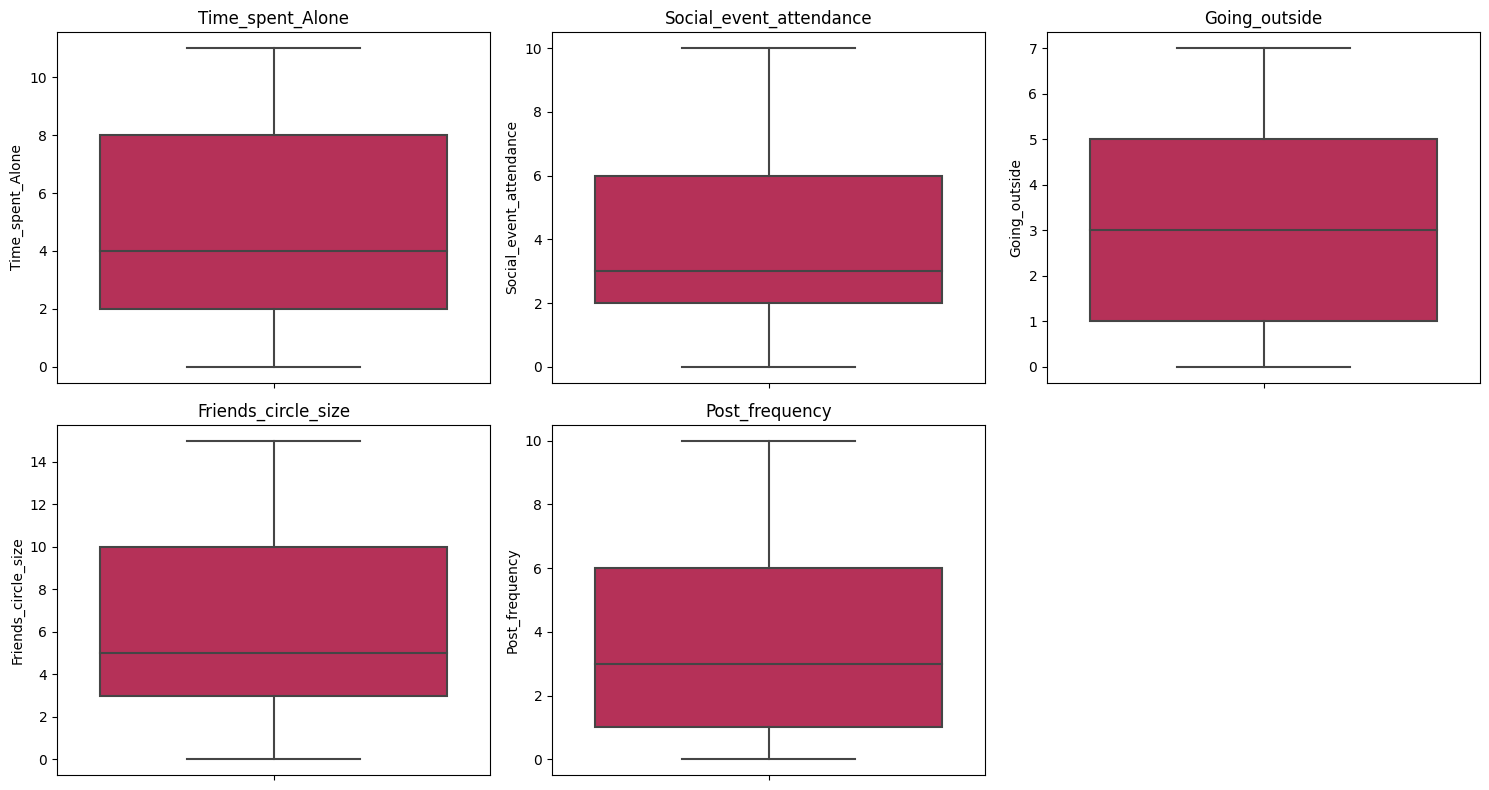

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define el número de columnas y filas para la cuadrícula
num_vars = len(numerical_columns.columns)
cols = 3  # Puedes ajustar este valor según prefieras
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(y=df[col], ax=axes[i], palette="rocket")
    axes[i].set_title(col)

# Elimina los ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

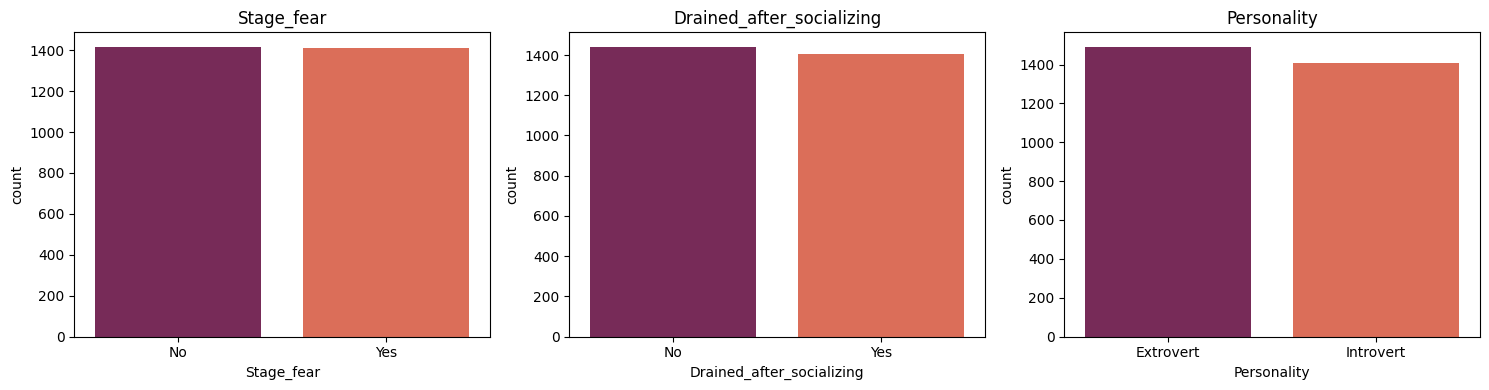

In [8]:
# Define el número de columnas y filas para la cuadrícula
num_vars = len(categorical_columns.columns)
cols = 3  # Puedes ajustar este valor según prefieras
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns.columns):
    sns.countplot(x=df[col], ax=axes[i], palette="rocket")
    axes[i].set_title(col)

# Elimina los ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

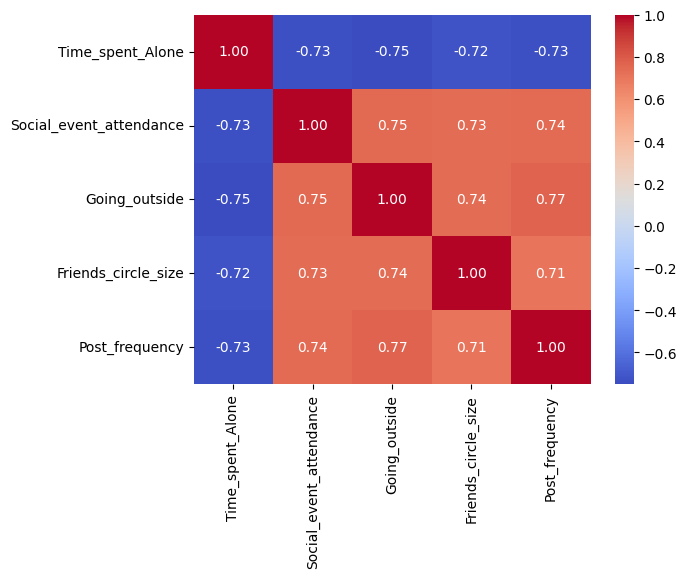

In [12]:
sns.heatmap(numerical_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Todas las características están fuertemente correlacionadas entre sí, ya sea positiva o negativamente. No obstante, antes de eliminar características, es recomendable evaluar la información mutua.

In [38]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance")

# Imputación de valores faltantes en las columnas numéricas
numerical_columns_imputed = imputer.fit_transform(numerical_columns)
categorical_columns_imputed = categorical_columns.fillna(categorical_columns.mode().iloc[0])

df_imputed = pd.DataFrame(
    data=pd.concat([pd.DataFrame(numerical_columns_imputed, columns=numerical_columns.columns),
                    categorical_columns_imputed], axis=1),
    columns=df.columns)

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [49]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Codifica las variables categóricas
le = LabelEncoder()
encoded_df = df_imputed.copy()
for col in categorical_columns.columns:
    encoded_df[col] = le.fit_transform(encoded_df[col])

# Escala las variables numéricas
for col in numerical_columns.columns:
    scaler = StandardScaler()
    encoded_df[col] = scaler.fit_transform(encoded_df[[col]])

encoded_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,-0.145031,0,0.013808,1.336572,0,1.571932,0.489874,0
1,1.295573,1,-1.366072,-1.336350,1,-1.466566,-0.194219,1
2,1.295573,1,-1.021102,-0.445376,1,-0.297913,-0.536265,1
3,-1.297515,0,0.703748,1.782059,0,1.805663,1.516013,0
4,-0.433152,0,1.738658,0.445598,0,0.403279,0.489874,0


/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, U

Text(0.5, 1.0, 'Mutual Information Scores')

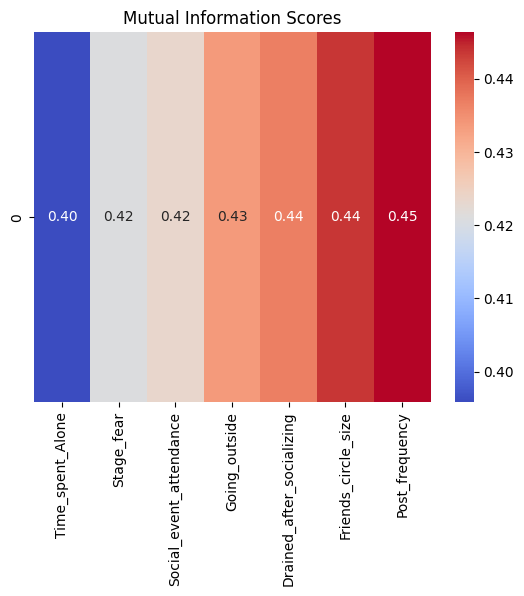

In [50]:
# Calcula la información mutua
mi_scores = np.sort(mutual_info_classif(encoded_df.drop("Personality", axis=1), encoded_df["Personality"], discrete_features=True))

sns.heatmap(pd.DataFrame(mi_scores.reshape(1, -1), columns=encoded_df.drop("Personality", axis=1).columns),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mutual Information Scores")

Por el momento, no me atrevo a realizar eliminación de características. Así que procederé a probar algunos modelos de machine learning para ver cómo se comportan. Se realizará Grid Search con Cross Validation para elegir el mejor modelo posible dentro del espacio de modelos analizados.

# Entrenamiento

En el caso de entrenar SVM, el escalado es [altamente recomendado](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use) (numeral 4).

In [51]:
from sklearn.model_selection import train_test_split
X = encoded_df.drop(columns=["Personality"])
y = encoded_df["Personality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
scorer = "f1"

## Redes neuronales
Se probaron 50 ajustes, de los cuales el que optimizó mejor la métrica f1 (con 0.92 en el set de pruebas) fue la configuración `'activation': 'relu', 'hidden_layer_sizes': (50,)`.

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
}

mlp = MLPClassifier(solver='sgd', max_iter=1000, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, scoring=scorer, n_jobs=-1, cv=5, verbose=1, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'activation': 'relu', 'hidden_layer_sizes': (50,)}
Best score:  0.9374867665924576
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       298
           1       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



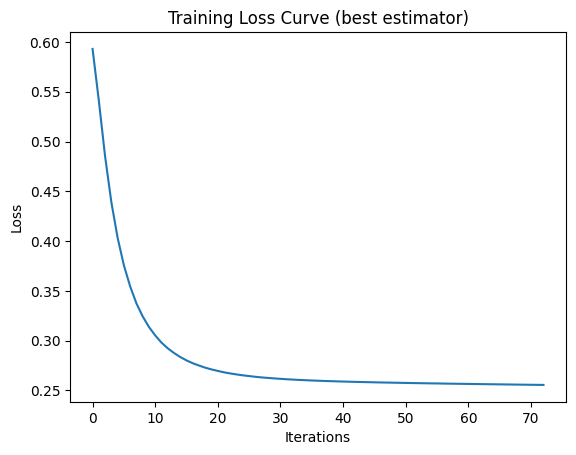

In [54]:
# Visualización de la pérdida durante el entrenamiento
plt.plot(grid_search.best_estimator_.loss_curve_)
plt.title("Training Loss Curve (best estimator)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## SVM
Se probaron 450 ajustes, donde el que mejor optimizó la métrica f1 (con un puntaje de 0.92 en el set de pruebas) se obtuvo con la configuración `'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'`.

In [58]:
from sklearn.svm import SVC

param_grid_svc = [
    {
        'kernel': ['rbf'],
        'C': np.linspace(0.01, 10, 10),
        'gamma': ['scale', 'auto']
    },
    {
        'kernel': ['linear'],
        'C': np.linspace(0.01, 10, 10)
    },
    {
        'kernel': ['poly'],
        'C': np.linspace(0.01, 10, 10),
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
]

svc = SVC(random_state=42)
grid_search_svc = GridSearchCV(svc, param_grid_svc, scoring=scorer, n_jobs=-1, cv=5, verbose=1, return_train_score=True)
grid_search_svc.fit(X_train, y_train)
print("Best parameters found for SVC: ", grid_search_svc.best_params_)
print("Best score for SVC: ", grid_search_svc.best_score_)
y_pred_svc = grid_search_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
cm_svc = confusion_matrix(y_test, y_pred_svc)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters found for SVC:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVC:  0.9374867665924576
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       298
           1       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



Este dataset está muy perfecto, ya me aburrió.